##### Stephanie Chiang
DATA 602 Fall 2024
Final Project

## A Study of Drug Use by Age Groups

**Abstract**

This analysis examines drug use across different age groups to identify trends and relationships in preferences and frequency. Using a dataset from FiveThirtyEight, the sample populations will be grouped by age in 15-year increments, from adolescence to elderly adulthood, and the rates of consumption of different substances, such as alcohol, cannabis, prescription drugs, and other substances, will be explored. The findings reveal clear age-related differences in drug popularity and usage frequencies, exposing how various factors such as legality, availabilty, health and peer usage may affect the populations. These insights provide actionable knowledge for healthcare providers and mental health professionals to shape outreach and improve treatments based on age.

**Introduction**

The data set is provided by (FiveThirtyEight)[http://fivethirtyeight.com/datalab/how-baby-boomers-get-high/] on their public (Github)[https://github.com/fivethirtyeight/data/tree/master/drug-use-by-age], and covers 13 drugs across 17 age groups. The `use` columns are the percentage of each age row that used the drug within the previous 12 months. The `frequency` is median number of times that users in the age group used the drug in the previous 12 months. This data will be used to explore the following:

- What patterns, if any, exist in drug use across different age groups? For example, are there age groups that exhibit higher use rates of a particular type of drug?
- Are there noticeable relationships between the frequency or popularity certain drugs? For example, does marijuana correlate with opioid use?

### DATA CLEANUP & TRANSFORMATION

First, the CSV is imported from Github, and the dimensions checked to confirm the successful capture of all data.

The missing values are converted from strings of "-" to `NaN` values and also counted for confirmation.

In [ ]:
import numpy as np
import pandas as pd

drug_data = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/refs/heads/master/drug-use-by-age/drug-use-by-age.csv")

print(f"Dimensions: {drug_data.shape}")

# convert "-" strings to NA
drug_data = drug_data.replace("-", np.nan)

print(f"Total missing values: {drug_data.isna().sum().sum()}")

# display a sample, the first 5 rows and 10 columns
print(drug_data.head().iloc[:, 0:10])

Dimensions: (17, 28)
Total missing values: 9
  age     n  alcohol_use  alcohol_frequency  marijuana_use  \
0  12  2798          3.9                3.0            1.1   
1  13  2757          8.5                6.0            3.4   
2  14  2792         18.1                5.0            8.7   
3  15  2956         29.2                6.0           14.5   
4  16  3058         40.1               10.0           22.5   

   marijuana_frequency  cocaine_use cocaine_frequency  crack_use  \
0                  4.0          0.1               5.0        0.0   
1                 15.0          0.1               1.0        0.0   
2                 24.0          0.1               5.5        0.0   
3                 25.0          0.5               4.0        0.1   
4                 30.0          1.0               7.0        0.0   

  crack_frequency  
0             NaN  
1             3.0  
2             NaN  
3             9.5  
4             1.0  


Since the age breakdowns are not regular (observations are recorded for each "teen" age, but at 35+ the ranges reach 15 years), some ages are combined and their values averaged to normalize the ranges.

In [262]:
# values for a new index column
new_idx = [0] * drug_data.shape[0]

for i in range(len(new_idx)):
  if i <= 7:
    new_idx[i] = "12-19"
  elif i <= 13:
    new_idx[i] = "20-34"
  else:
    new_idx[i] = drug_data.iloc[i]["age"]

# add the new index column for aggregation
drug_data["age_range"] = new_idx

# confirm the age_range column was added correctly
print(drug_data.head().iloc[:, -3:])

   sedative_use  sedative_frequency age_range
0           0.2                13.0     12-19
1           0.1                19.0     12-19
2           0.2                16.5     12-19
3           0.4                30.0     12-19
4           0.2                 3.0     12-19


Now, the data can be grouped by `age_range` into a new data frame with more regular age ranges.

This new data frame can also be pivoted into a tidier, longer format for easier grouping and analysis. The goal is to have one observation per row.
The `substance` column will be split, and the numerical columns rounded.

In [263]:
# group
grp_drug = drug_data.groupby(["age_range"], as_index=False).mean(numeric_only=True)

# pivot
grp_drug = grp_drug.melt(id_vars=["age_range", "n"], var_name="substance", value_name="result")

print(grp_drug)

   age_range            n           substance      result
0      12-19  2761.375000         alcohol_use   34.050000
1      20-34  3235.833333         alcohol_use   79.733333
2      35-49  7391.000000         alcohol_use   75.000000
3      50-64  3923.000000         alcohol_use   67.200000
4        65+  2448.000000         alcohol_use   49.300000
..       ...          ...                 ...         ...
95     12-19  2761.375000  sedative_frequency   13.000000
96     20-34  3235.833333  sedative_frequency   16.083333
97     35-49  7391.000000  sedative_frequency   10.000000
98     50-64  3923.000000  sedative_frequency  104.000000
99       65+  2448.000000  sedative_frequency   15.000000

[100 rows x 4 columns]


In [264]:
# column split and cleanup
temp = grp_drug["substance"].str.split("_", n=1, expand=True)
grp_drug["substance"] = temp[0]
grp_drug["value_type"] = temp[1]

grp_drug["n"] = grp_drug["n"].round(0)
grp_drug["result"] = grp_drug["result"].round(2)
grp_drug = grp_drug.iloc[:, [0, 1, 2, 4, 3]]

print(grp_drug)

   age_range       n substance value_type  result
0      12-19  2761.0   alcohol        use   34.05
1      20-34  3236.0   alcohol        use   79.73
2      35-49  7391.0   alcohol        use   75.00
3      50-64  3923.0   alcohol        use   67.20
4        65+  2448.0   alcohol        use   49.30
..       ...     ...       ...        ...     ...
95     12-19  2761.0  sedative  frequency   13.00
96     20-34  3236.0  sedative  frequency   16.08
97     35-49  7391.0  sedative  frequency   10.00
98     50-64  3923.0  sedative  frequency  104.00
99       65+  2448.0  sedative  frequency   15.00

[100 rows x 5 columns]


For even more clarity, the dataframe can now be split into 2 tables based on the `value_type`.

In [265]:
val_groups = grp_drug.groupby("value_type")
grp_dfs = {group_name: group_data for group_name, group_data in val_groups}

# frequency values only
freq_df = grp_dfs["frequency"]
print(freq_df.head(10))

   age_range       n  substance value_type  result
5      12-19  2761.0    alcohol  frequency   12.88
6      20-34  3236.0    alcohol  frequency   51.33
7      35-49  7391.0    alcohol  frequency   52.00
8      50-64  3923.0    alcohol  frequency   52.00
9        65+  2448.0    alcohol  frequency   52.00
15     12-19  2761.0  marijuana  frequency   30.75
16     20-34  3236.0  marijuana  frequency   58.00
17     35-49  7391.0  marijuana  frequency   48.00
18     50-64  3923.0  marijuana  frequency   52.00
19       65+  2448.0  marijuana  frequency   36.00


In [266]:
# proportions of use only
subuse_df = grp_dfs["use"]
print(subuse_df.head(10))

   age_range       n  substance value_type  result
0      12-19  2761.0    alcohol        use   34.05
1      20-34  3236.0    alcohol        use   79.73
2      35-49  7391.0    alcohol        use   75.00
3      50-64  3923.0    alcohol        use   67.20
4        65+  2448.0    alcohol        use   49.30
10     12-19  2761.0  marijuana        use   18.16
11     20-34  3236.0  marijuana        use   26.25
12     35-49  7391.0  marijuana        use   10.40
13     50-64  3923.0  marijuana        use    7.30
14       65+  2448.0  marijuana        use    1.20


### DATA ANALYSIS

The data can now be used to answer the research questions regarding participation rates and frequency of use for different substances among different age groups.

##### What patterns, if any, exist in drug use across different age groups? For example, are there age groups that exhibit higher use rates of a particular type of drug?

The percent of alcohol use for every age group far outstrips that of any other substance. For clarity, these values are plotted separately.

Then after alcohol, the most "popular" substance by far is marijuana. The 2nd grouped bar chart removes marijuana for a more granular visualization of the participation rates for the various substances. Perhaps as expected, the under 35 population shows higher proportions for users than the older generations, and also with more diverse "tastes", so to speak.

In [267]:
import seaborn as sns
import matplotlib.pyplot as plt

# dataframes for alcohol only, all substances and subtances without marijuana
alcohol_df = subuse_df[subuse_df["substance"] == "alcohol"]
subuse_df = subuse_df[subuse_df["substance"] != "alcohol"]
nomj_df = subuse_df[subuse_df["substance"] != "marijuana"]

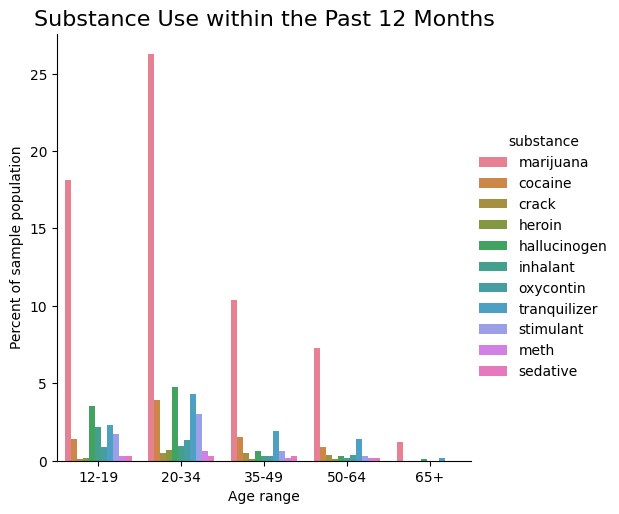

In [268]:
# all non-alcohol substances
sns.catplot(
  x = "age_range",
  y = "result",
  hue = "substance",
  data = subuse_df,
  kind = "bar",
)

plt.xlabel("Age range")
plt.ylabel("Percent of sample population")
plt.title("Substance Use within the Past 12 Months", fontsize = 16)

plt.show()

Here is the same plot, with marijuana removed.

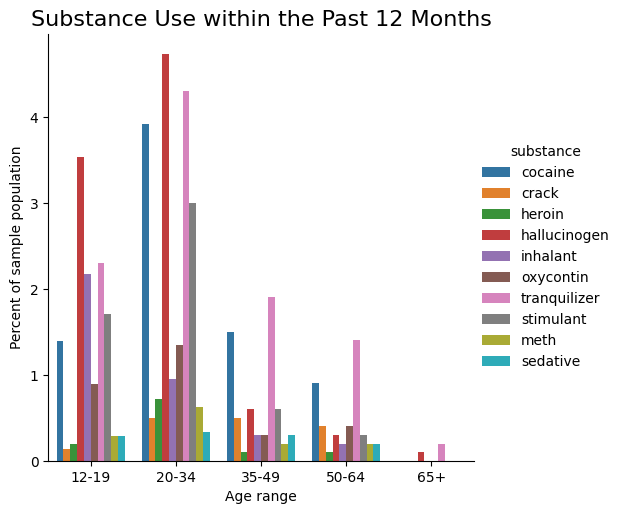

In [269]:
sns.catplot(
  x = "age_range",
  y = "result",
  hue = "substance",
  data = nomj_df,
  kind = "bar",
)

plt.xlabel("Age range")
plt.ylabel("Percent of sample population")
plt.title("Substance Use within the Past 12 Months", fontsize = 16)

plt.show()

Now, the frequency of alcohol use separately, which demonstrates how the affects of legal drinking age and general availabilty affects participation.

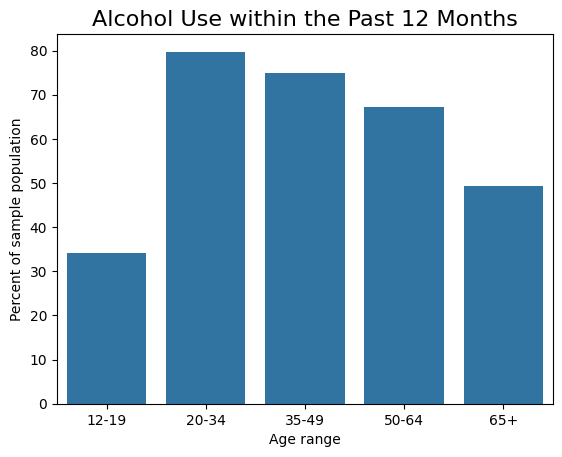

In [270]:
sns.barplot(
  x = "age_range",
  y = "result",
  data = alcohol_df,
)

plt.xlabel("Age range")
plt.ylabel("Percent of sample population")
plt.title("Alcohol Use within the Past 12 Months", fontsize = 16)

plt.show()

The frequency values of each substance that "users" of each age group also provide interesting results.

Though the 65+ group had the lowest participation rates of every substance, with no statistically relevant proportion recorded for several on the list, the median frequencies of use did not significantly differ from the other age groups. In particular, the frequency of stimulant use was extremely high, the highest of all. With the population proportion listed at a statistically insignificant 0.0, and use frequency of 364 times (nearly everyday), this indicates an outlier in the data set - perhaps just one person who skewed these results.

The 50-64 age group also contains some interesting outliers, but with less extreme magnitudes of difference. They show the highest frequency of sedative and hallucinogenic use.

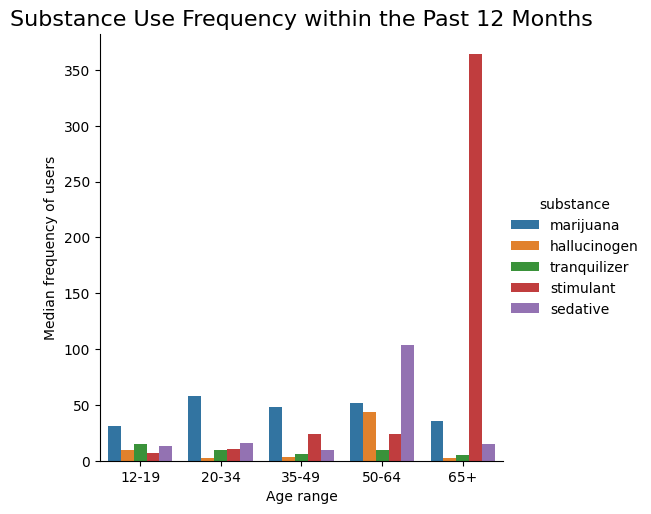

In [271]:
freq_df = freq_df[freq_df["substance"] != "alcohol"]

freq_plot = sns.catplot(
  x = "age_range",
  y = "result",
  hue = "substance",
  data = freq_df,
  kind = "bar",
)

plt.xlabel("Age range")
plt.ylabel("Median frequency of users")
plt.title("Substance Use Frequency within the Past 12 Months", fontsize = 16)

plt.show()

Here are the most and least "popular" substances by age group:

In [272]:
max_use_idx = subuse_df.groupby("age_range")["result"].idxmax()
max_use = subuse_df.loc[max_use_idx]

print(max_use)

min_use_idx = subuse_df.groupby("age_range")["result"].idxmin()
min_use = subuse_df.loc[min_use_idx]

print(min_use)

   age_range       n  substance value_type  result
10     12-19  2761.0  marijuana        use   18.16
11     20-34  3236.0  marijuana        use   26.25
12     35-49  7391.0  marijuana        use   10.40
13     50-64  3923.0  marijuana        use    7.30
14       65+  2448.0  marijuana        use    1.20
   age_range       n substance value_type  result
25     12-19  2761.0     crack        use    0.14
91     20-34  3236.0  sedative        use    0.33
32     35-49  7391.0    heroin        use    0.10
33     50-64  3923.0    heroin        use    0.10
24       65+  2448.0   cocaine        use    0.00


And here are the age groups with the highest and lowest median number of uses in the past year for each drug:

In [280]:
max_freq_idx = freq_df.groupby("substance")["result"].idxmax()
max_freq = freq_df.loc[max_freq_idx]

print(max_freq)

min_freq_idx = freq_df.groupby("substance")["result"].idxmin()
min_freq = freq_df.loc[min_freq_idx]

print(min_freq)

   age_range       n     substance value_type  result
43     50-64  3923.0  hallucinogen  frequency   44.00
16     20-34  3236.0     marijuana  frequency   58.00
98     50-64  3923.0      sedative  frequency  104.00
84       65+  2448.0     stimulant  frequency  364.00
70     12-19  2761.0  tranquilizer  frequency   15.19
   age_range       n     substance value_type  result
44       65+  2448.0  hallucinogen  frequency    2.00
15     12-19  2761.0     marijuana  frequency   30.75
97     35-49  7391.0      sedative  frequency   10.00
80     12-19  2761.0     stimulant  frequency    7.06
74       65+  2448.0  tranquilizer  frequency    5.00


So, the data has revealed that although alcohol and marijuana are generally the most widely and frequently used substances, there are some trends noticeable by age group. Percentages of hallucinogenics and inhalants, for example, differ significantly in the population based on age group.

##### Are there noticeable relationships between the frequency or popularity certain drugs? For example, does marijuana use correlate with opioid use?

Below is a presentation of a correlation matrix between the proportions of age groups that used `marijuana` and the other drugs in the survey.

In [274]:
# pivot wider again for correlation
use_corr = subuse_df.pivot(index="age_range", columns="substance", values="result")
correlation_matrix = use_corr.corr()
marijuana_corr = correlation_matrix["marijuana"].sort_values(ascending=False)

print(marijuana_corr)

substance
marijuana       1.000000
oxycontin       0.982428
stimulant       0.981854
tranquilizer    0.974796
meth            0.960199
hallucinogen    0.957875
cocaine         0.928600
heroin          0.901355
sedative        0.826518
inhalant        0.670386
crack           0.485423
Name: marijuana, dtype: float64


Several of the drugs have high correlation coefficients with the proportion of `marijuana` usage. The top 3, `oxycontin`, `stimulant` and `tranquilizer` are visualized below with their linear regression models fit:

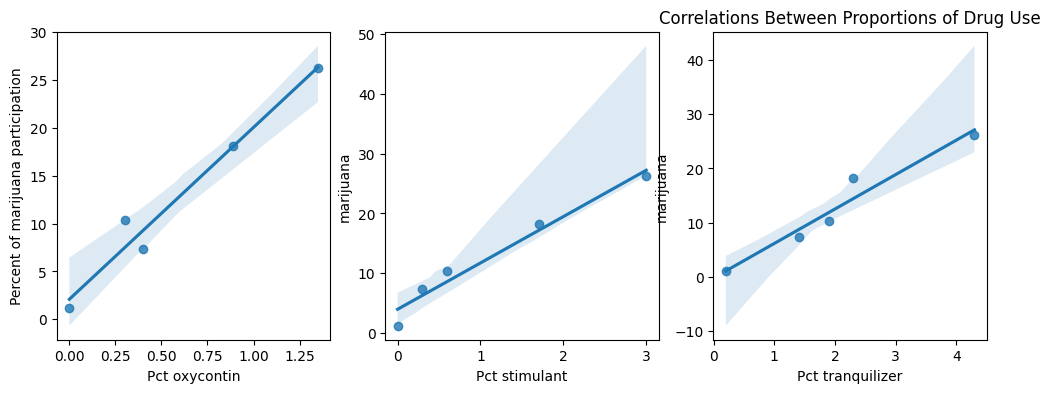

In [275]:
fig, axs = plt.subplots(figsize=(12, 4), ncols = 3)

sns.regplot(
  data = use_corr,
  x = "oxycontin",
  y = "marijuana",
  ax = axs[0],
)
axs[0].set_xlabel("Pct oxycontin")
axs[0].set_ylabel("Percent of marijuana participation")

sns.regplot(
  data = use_corr,
  x = "stimulant",
  y = "marijuana",
  ax = axs[1],
)
axs[1].set_xlabel("")
axs[1].set_xlabel("Pct stimulant")

sns.regplot(
  data = use_corr,
  x = "tranquilizer",
  y = "marijuana",
  ax = axs[2],
)
axs[2].set_xlabel("")
axs[2].set_xlabel("Pct tranquilizer")

plt.title("Correlations Between Proportions of Drug Use")

plt.show()

### CONCLUSION

To answer the questions posed at the start of this analysis, there are some notable patterns in drug use across different age groups. Though every group had the highest percentage of participants with alcohol and marijuana (likely due to legality), the following trends were of note:

**Younger Adults (20-34 years)**:
   - Highest proportion of participants for every substance, except for `inhalants` (which had a higher teen percentage).

**Older Adults (50-64 years)**:
   - Highest frequency of use for nearly every substance, with particular "preference" for hallucinogens and sedatives.

**Elderly Adults (65+ years)**:
   - Lowest rates of participation and frequency, but with outliers.

The data was also able to illuminate noticeable relationships between marijuana and nearly every other substance. And in fact, only alcohol had a low correlation coefficient: 0.236558. Therefore, marijuana correlates positively with increases in the proportion of the population that use illicit substances.

These trends underscore the importance of targeted prevention and intervention strategies tailored to the unique needs of each age group.
